<a href="https://colab.research.google.com/github/Coyote-Schmoyote/dog-classification-deep-learning/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class iamge classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog. 

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition. 
Link: https://www.kaggle.com/c/dog-breed-identification 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

Link: https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation 

## 4. Features

Some information about the data: 
* We're dealing with images (unstructured data), so it's probably best we use deep learning/transfer learning
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels)

In [ ]:
# Import data

Get our workspace ready

In [ ]:
# Import TensorFlow
import tensorflow as tf
print("TF version:", tf.__version__)

# Import TensorFlowHub
import tensorflow_hub as hub 
print("TF Hub version:", hub.__version__)

# Make sure we're using GPU
print("GPU", "availbale (YESSSSS)" if tf.config.list_physical_devices("GPU") else "not available :(")


TF version: 2.8.0
TF Hub version: 0.12.0
GPU availbale (YESSSSS)


## Getting our data ready (turning it into Tensors)
With all machine learning models, 
our data has to be in a numerical format. So that's what we'll be doing first.
Turning our images into Tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data 
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog-vision-project/data/labels.csv")

In [ ]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


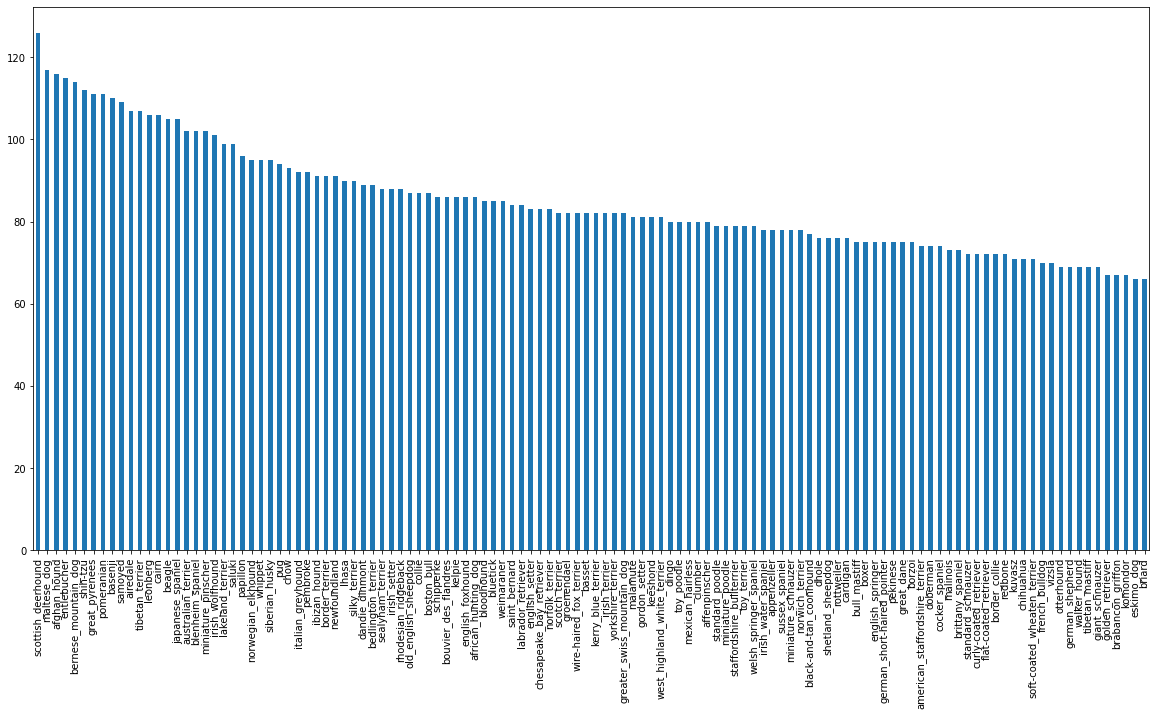

In [ ]:
 #How many images are there of each breed?
 labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

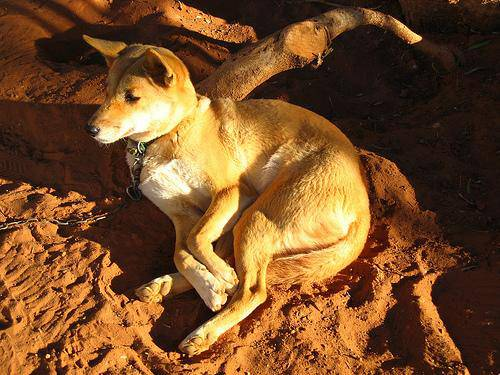

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/dog-vision-project/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

# Getting images and their labels
Let's get a list of all our image file pathnames

In [ ]:
# Create pathnames from image IDs
filenames = ["drive/MyDrive/dog-vision-project/data/train/" + fname + ".jpg" for fname in labels_csv["id"]]
             
#Check first 10
filenames [:10]

['drive/MyDrive/dog-vision-project/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog-vision-project/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog-vision-project/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog-vision-project/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog-vision-project/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog-vision-project/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog-vision-project/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog-vision-project/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog-vision-project/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog-vision-project/data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/dog-vision-project/data/train")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files!


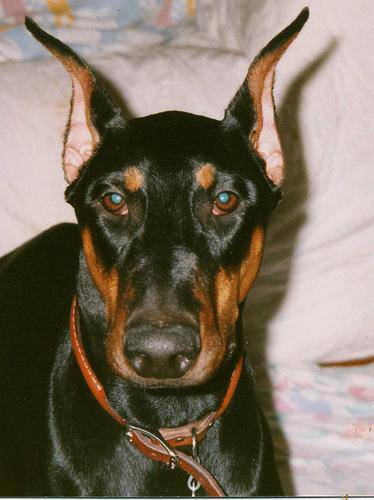

In [ ]:
# One more check 
Image(filenames[9001])


In [ ]:
labels_csv["breed"][9001]

'doberman'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
import numpy as np 

In [ ]:
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:20]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs ina boolean array
print(boolean_labels[0].astype(int)) #there will be 1 where the sample is True

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to split it by ourselves

In [ ]:
# Setup X and y variables
X = filenames
y = boolean_labels 

In [ ]:
len(filenames)

10222

We are going to start experimenting with ~1000 images

In [ ]:
# Set number of images to use for experimenting 
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Split the data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a quick look at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/dog-vision-project/data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog-vision-project/data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False

# preprocessing images (turning them into Tensors

To preprocess our images into tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize `image` to be a shape of (224, 224)
5. return the modified `image`

In [ ]:
# Example: Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Take an image filepath as input
Use TensorFlow to read the file and save it to a variable image
Turn our image (a jpg) into Tensors
Resize image to be a shape of (224, 224)
return the modified image

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel from 0-255 to 0-1)
5. Resize image to be a shape of (224, 224)
6. Return the modified image

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns an image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32) 

  #Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turn data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ imagines in one go, they all might not fit into memory. 

That's why we do about 32 (one batch size) images at a time (you can adjust batch size manually if you need)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """

  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data our of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) #only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE) 
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths 
                                               tf.constant(y))) #labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data
  
  # Training batch
  else: 
    print("Creating training data batches...")
    #Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    #Create (image, label) tuples (this also turns the image path into a pre-proicessed image)
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch 


In [ ]:
# Create training and validation data batches
val_data = create_data_batches(X_val, y_val, valid_data=True)
train_data = create_data_batches(X_train, y_train)


Creating validation data batches...
Creating training data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(120,), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand, let's visualize them.

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  plt.figure(figsize=(10, 10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplots (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[6.80322200e-02, 1.11169480e-01, 7.97969252e-02],
          [8.40511248e-02, 1.27188385e-01, 9.58158299e-02],
          [4.69362736e-02, 9.00735334e-02, 5.87009788e-02],
          ...,
          [2.66805012e-02, 9.72687379e-02, 1.47933075e-02],
          [2.01156344e-02, 9.07038748e-02, 0.00000000e+00],
          [2.35294141e-02, 9.41176564e-02, 0.00000000e+00]],
 
         [[5.80634251e-02, 1.01200685e-01, 6.98281303e-02],
          [8.65078866e-02, 1.29645139e-01, 9.82725918e-02],
          [6.20705709e-02, 1.05207831e-01, 7.38352761e-02],
          ...,
          [6.20832928e-02, 1.30624235e-01, 3.06206848e-02],
          [4.80375327e-02, 1.09885320e-01, 1.77956987e-02],
          [3.80494706e-02, 1.08023591e-01, 7.46473717e-03]],
 
         [[6.98210225e-02, 1.12958282e-01, 8.15857276e-02],
          [9.77143273e-02, 1.40283108e-01, 1.08910568e-01],
          [7.53485337e-02, 1.15220733e-01, 8.38481858e-02],
          ...,
          [9.19529423e-02, 1.51417553e-01, 5.9251

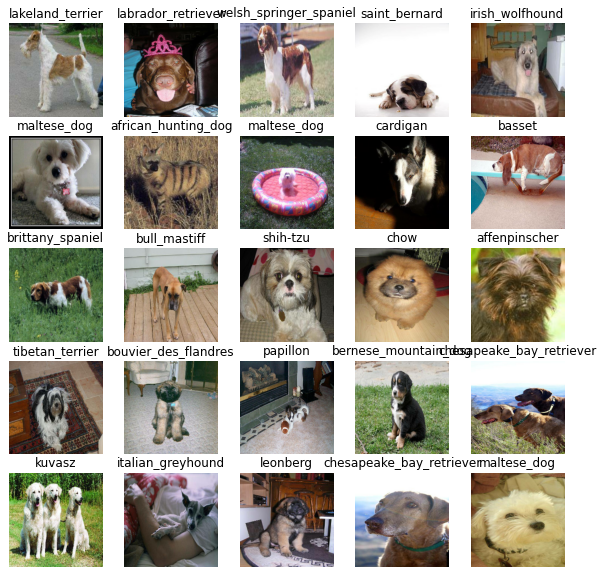

In [ ]:
# Now let's visualize the data in training batch
show_25_images(train_images, train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The unput shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels in the form of Tesnors)
* The URL of the model we want to use from TensorFlow Hub (https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch height, width, color channels

#Setup shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5"

In [ ]:
len(unique_breeds)

120

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameteres.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Complies the model (says it should be evaluated and improved)
* Build the model (tell the model the input shape it'll be getting)
* Returns the model

All of these steps can now be found here: https://tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which build a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), #Leayer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2 (output later)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)
  print("The model is built!")

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/classification/5
The model is built!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              2664345   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 2,784,585
Trainable params: 120,240
Non-trainable params: 2,664,345
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, checks its progress to stop training early if a model stops improving.

We'll create two callbacks: one for TensorBoard which helps track our models progress and another for early stopiing which prevents our model from training too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things: 
1. Load the Tensorboard notebook extension
2. Create a TenorBoard callback which is able to save logs to a directory, and pass it to out model's `fit()` function
3. Visualize our model's training logs with the `%tensorboard` magic function (after the model training)

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard 

In [ ]:
import datetime 

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/dog-vision-prject/logs",
  # Make it so the logs get tracked whenever we run an experiment
                                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

#### Create early stopping callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)